In [ ]:
import torch
import torch.nn as nn
import os
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.data import DataLoader,Dataset

In [ ]:
device =( "cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(device)
print(device)

cpu


In [ ]:
dirs="/content/drive/MyDrive/dataset/cityscapes_data/real_img/"

In [ ]:
def split_img(img):
  img_array=np.array(img)
  cityscape,label=img_array[:,:256,:],img_array[:,256:,:]
  return cityscape,label

In [ ]:
X=[]
Y=[]
for img in os.listdir(dirs):
  path=os.path.join(dirs,img)
  sample_img=Image.open(path).convert("RGB")
  cityscape,label=split_img(sample_img)
  #cityscape,label=Image.fromarray(cityscape),Image.fromarray(cityscape)
  x=np.array(cityscape)
  y=np.array(label)
  X.append(x)
  Y.append(y)

In [ ]:
len(X),len(Y)

(200, 200)

In [ ]:
X_tensor=torch.tensor([x for x in X],dtype=torch.float)

In [ ]:
X_tensor=X_tensor/255.0

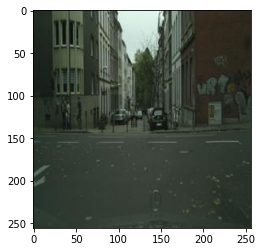

In [ ]:
plt.imshow(X_tensor[0])
plt.show()

In [ ]:
Y_tensor=torch.tensor([x for x in Y],dtype=torch.long)

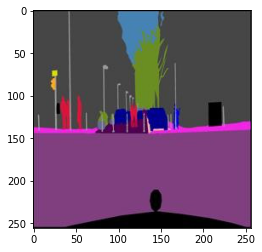

In [ ]:
plt.imshow(Y_tensor[0])
plt.show()

In [ ]:
num_items=1000
color_array=np.random.choice(range(256),3*num_items).reshape(-1,3)

In [ ]:
print(color_array.shape)

(1000, 3)


In [ ]:
print(color_array[0])

[144  26  11]


In [ ]:
num_classes=10
label_model=KMeans(n_clusters=num_classes)
label_model.fit(color_array)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
label_model.predict(color_array[:5, :])

array([2, 3, 7, 8, 3], dtype=int32)

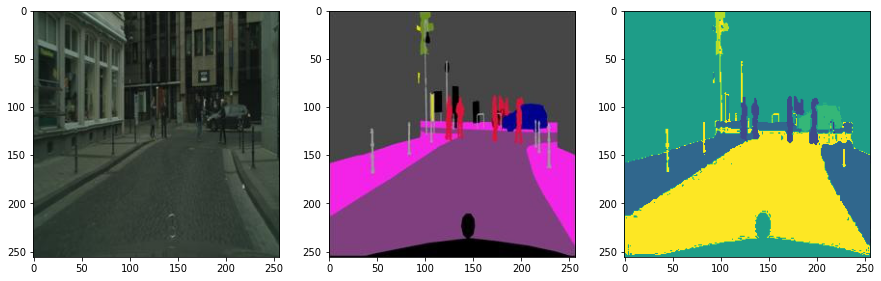

In [ ]:
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [ ]:
class CityscapeDataset(Dataset):
  def __init__(self,images_dir,label_model):
    self.images_dir=images_dir
    self.image_fns = os.listdir(images_dir)
    self.label_model=label_model

  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self,index):
    image_fns=self.image_fns[index]
    images_fp=os.path.join(self.images_dir,image_fns)
    image=Image.open(images_fp).convert("RGB")
    image=np.array(image)
    cityscape,label=self.split_img(image)
    label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
    cityscape = self.transform(cityscape)
    label_class = torch.Tensor(label_class).long()
    return cityscape, label_class


  def split_img(self,img):
    img_array=np.array(img)
    cityscape,label=img_array[:,:256,:],img_array[:,256:,:]
    return cityscape,label


  def transform(self,image):
    transform_ops=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
    return transform_ops(image)


In [ ]:
dataset = CityscapeDataset(dirs,label_model)

In [ ]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


In [ ]:
class UNet(nn.Module):
  def __init__(self,in_channel,out_channel):
    super(UNet,self).__init__()
    self.conv1=self.contract_block(in_channel,32,7,3)
    self.conv2=self.contract_block(32,64,3,1)
    self.conv3=self.contract_block(64,128,3,1)

    self.up_sample1=self.expand_block(128,64,3,1)
    self.up_sample2=self.expand_block(64*2,32,3,1)
    self.up_sample3=self.expand_block(32*2,out_channel,3,1)

  

  def forward(self,x):
    conv1=self.conv1(x)
    conv2=self.conv2(conv1)
    conv3=self.conv3(conv2)

    upconv1=self.up_sample1(conv3)
    upconv2=self.up_sample2(torch.cat([upconv1,conv2],1))
    upconv3=self.up_sample3(torch.cat([upconv2,conv1],1))

    return upconv3


  def contract_block(self,in_channel,out_channel,kernel_size,padding):
    contract=nn.Sequential(nn.Conv2d(in_channel,out_channel,kernel_size=kernel_size,stride=1,padding=padding),
                              nn.BatchNorm2d(out_channel),
                              nn.ReLU(),
                              nn.Conv2d(out_channel,out_channel,kernel_size=kernel_size,stride=1,padding=padding),
                              nn.BatchNorm2d(out_channel),
                              nn.ReLU(),
                              nn.MaxPool2d(3,2,1))
      
      
    return contract
      
  def expand_block(self,in_channel,out_channel,kernel_size,padding):
    expand=nn.Sequential(
            nn.Conv2d(in_channels=in_channel,out_channels=out_channel,kernel_size=kernel_size,stride=1,padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channel,out_channels=out_channel,kernel_size=kernel_size,stride=1,padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.ConvTranspose2d(out_channel,out_channel,kernel_size=kernel_size,stride=2,padding=1,output_padding=1))
        
    return expand



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=UNet(3,10).to(device)
model

UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kerne

In [ ]:
data_loader=DataLoader(dataset,batch_size=32,shuffle=True)

In [ ]:
x,y=next(iter(data_loader))

In [ ]:
x.shape,y.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 256]))

In [ ]:
epochs = 20
lr = 0.01

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = -1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
      X, Y = X.to(device), Y.to(device)
      Y_pred = model(X)
      loss = criterion(Y_pred, Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))



  0%|          | 0/20 [00:00<?, ?it/s]


  0%|          | 0/7 [00:00<?, ?it/s]


 14%|█▍        | 1/7 [00:28<02:51, 28.63s/it]


 29%|██▊       | 2/7 [00:55<02:20, 28.18s/it]


 43%|████▎     | 3/7 [01:23<01:51, 27.91s/it]


 57%|█████▋    | 4/7 [01:49<01:22, 27.54s/it]


 71%|███████▏  | 5/7 [02:16<00:54, 27.46s/it]


 86%|████████▌ | 6/7 [02:44<00:27, 27.33s/it]


100%|██████████| 7/7 [02:50<00:00, 21.20s/it]


                                             

  5%|▌         | 1/20 [02:50<54:07, 170.92s/it]


  0%|          | 0/7 [00:00<?, ?it/s]


 14%|█▍        | 1/7 [00:27<02:42, 27.03s/it]


 29%|██▊       | 2/7 [00:54<02:15, 27.02s/it]


 43%|████▎     | 3/7 [01:21<01:48, 27.01s/it]


 57%|█████▋    | 4/7 [01:47<01:20, 26.93s/it]


 71%|███████▏  | 5/7 [02:14<00:53, 26.98s/it]


 86%|████████▌ | 6/7 [02:42<00:27, 27.08s/it]


100%|██████████| 7/7 [02:49<00:00, 21.01s/it]


                                             

 10%|█         | 2/20 [05:39<51:06, 170.35s/it]


  0%|      

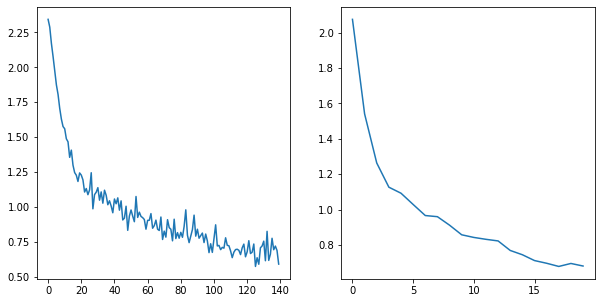

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [ ]:
model_name = "/content/drive/MyDrive/dataset/cityscapes_data/U-Net.pth"
torch.save(model.state_dict(), model_name)

In [ ]:
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [ ]:
test_batch_size = 8
data_loader_pred = DataLoader(dataset, batch_size=test_batch_size)

In [ ]:
X, Y = next(iter(data_loader_pred))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

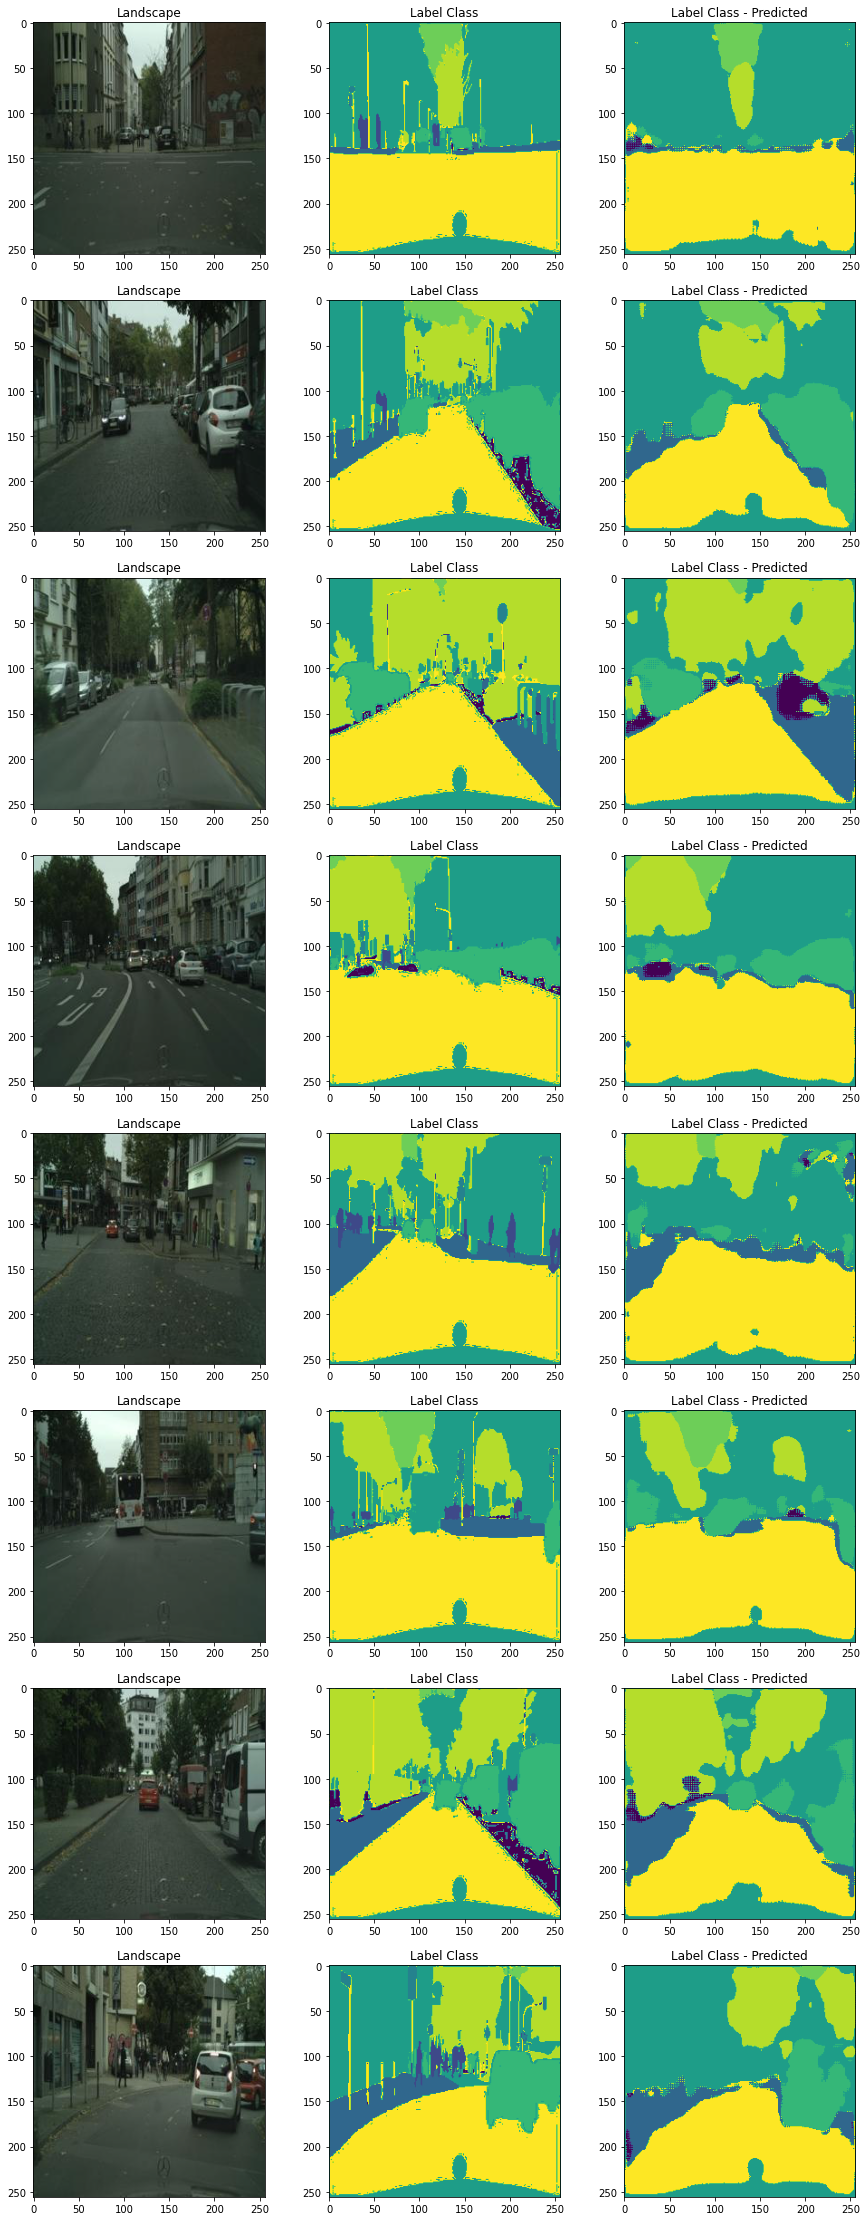

In [ ]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")